## Zwally basins

The Zwally basins are one way of splitting up Antarctica into its component glacier basins, which can be useful to studying different regions and their local drivers. We have various masks saved in netcdf which can be used to make these calculations on BISICLES data, although some of them need some pre-processing done to them first.

There are two main versions of the masks – with and without ice shelves / ocean included. Which is most useful somewhat depends on how it's being used, if it's being compared against observational data, which mask that observational data used, etcetc.

In [2]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np

### Without ice shelves

In [30]:
zwally = xr.open_dataset('data/zwally_basins_1km_cropped.nc')
x = zwally.x
y = zwally.y
mask = zwally.basins

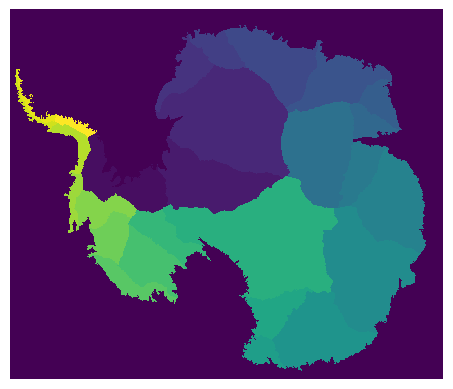

In [31]:
fig = plt.figure()
ax = plt.axes()
ax.pcolormesh(x, y, mask)
ax.set_aspect('equal')
ax.set_axis_off()

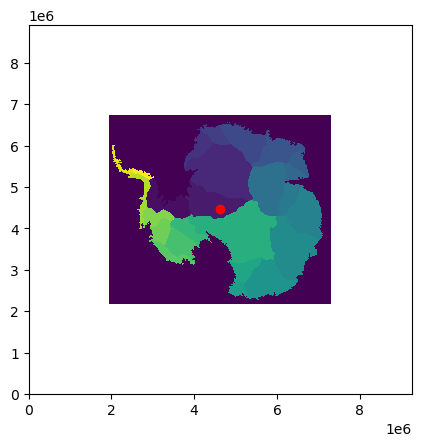

In [32]:
midx = (min(x)+max(x))/2
midy = (min(y)+max(y))/2

fig, ax = plt.subplots()

ax.pcolormesh(x, y, mask)
ax.set_xlim([0, max(x)+min(x)])
ax.set_ylim([0, max(y)+min(y)])
ax.set_aspect('equal')
ax.scatter(midx, midy, c='r')

In [33]:
xs = x - midx
ys = y - midy

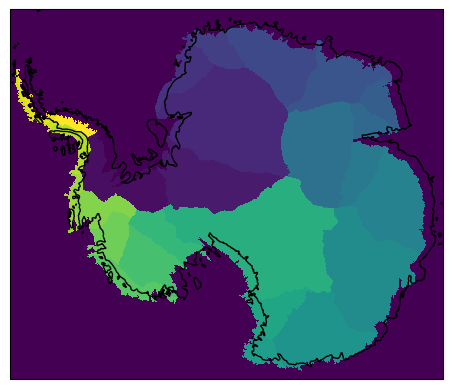

In [34]:
centered = zwally.assign_coords(x=xs, y=ys)

fig = plt.figure()
ax = plt.axes(projection=ccrs.SouthPolarStereo())

kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)
ax.pcolormesh(xs, ys, centered.basins, transform = ccrs.Stereographic(**kw))
ax.set_aspect('equal')
ax.coastlines()

This looks like the 'centered' zwally grid is in fact not centered. i.e. the centre of the grid does not align with the South pole. Below we define x and y offsets such that the south pole lies on the coordinate (0,0)

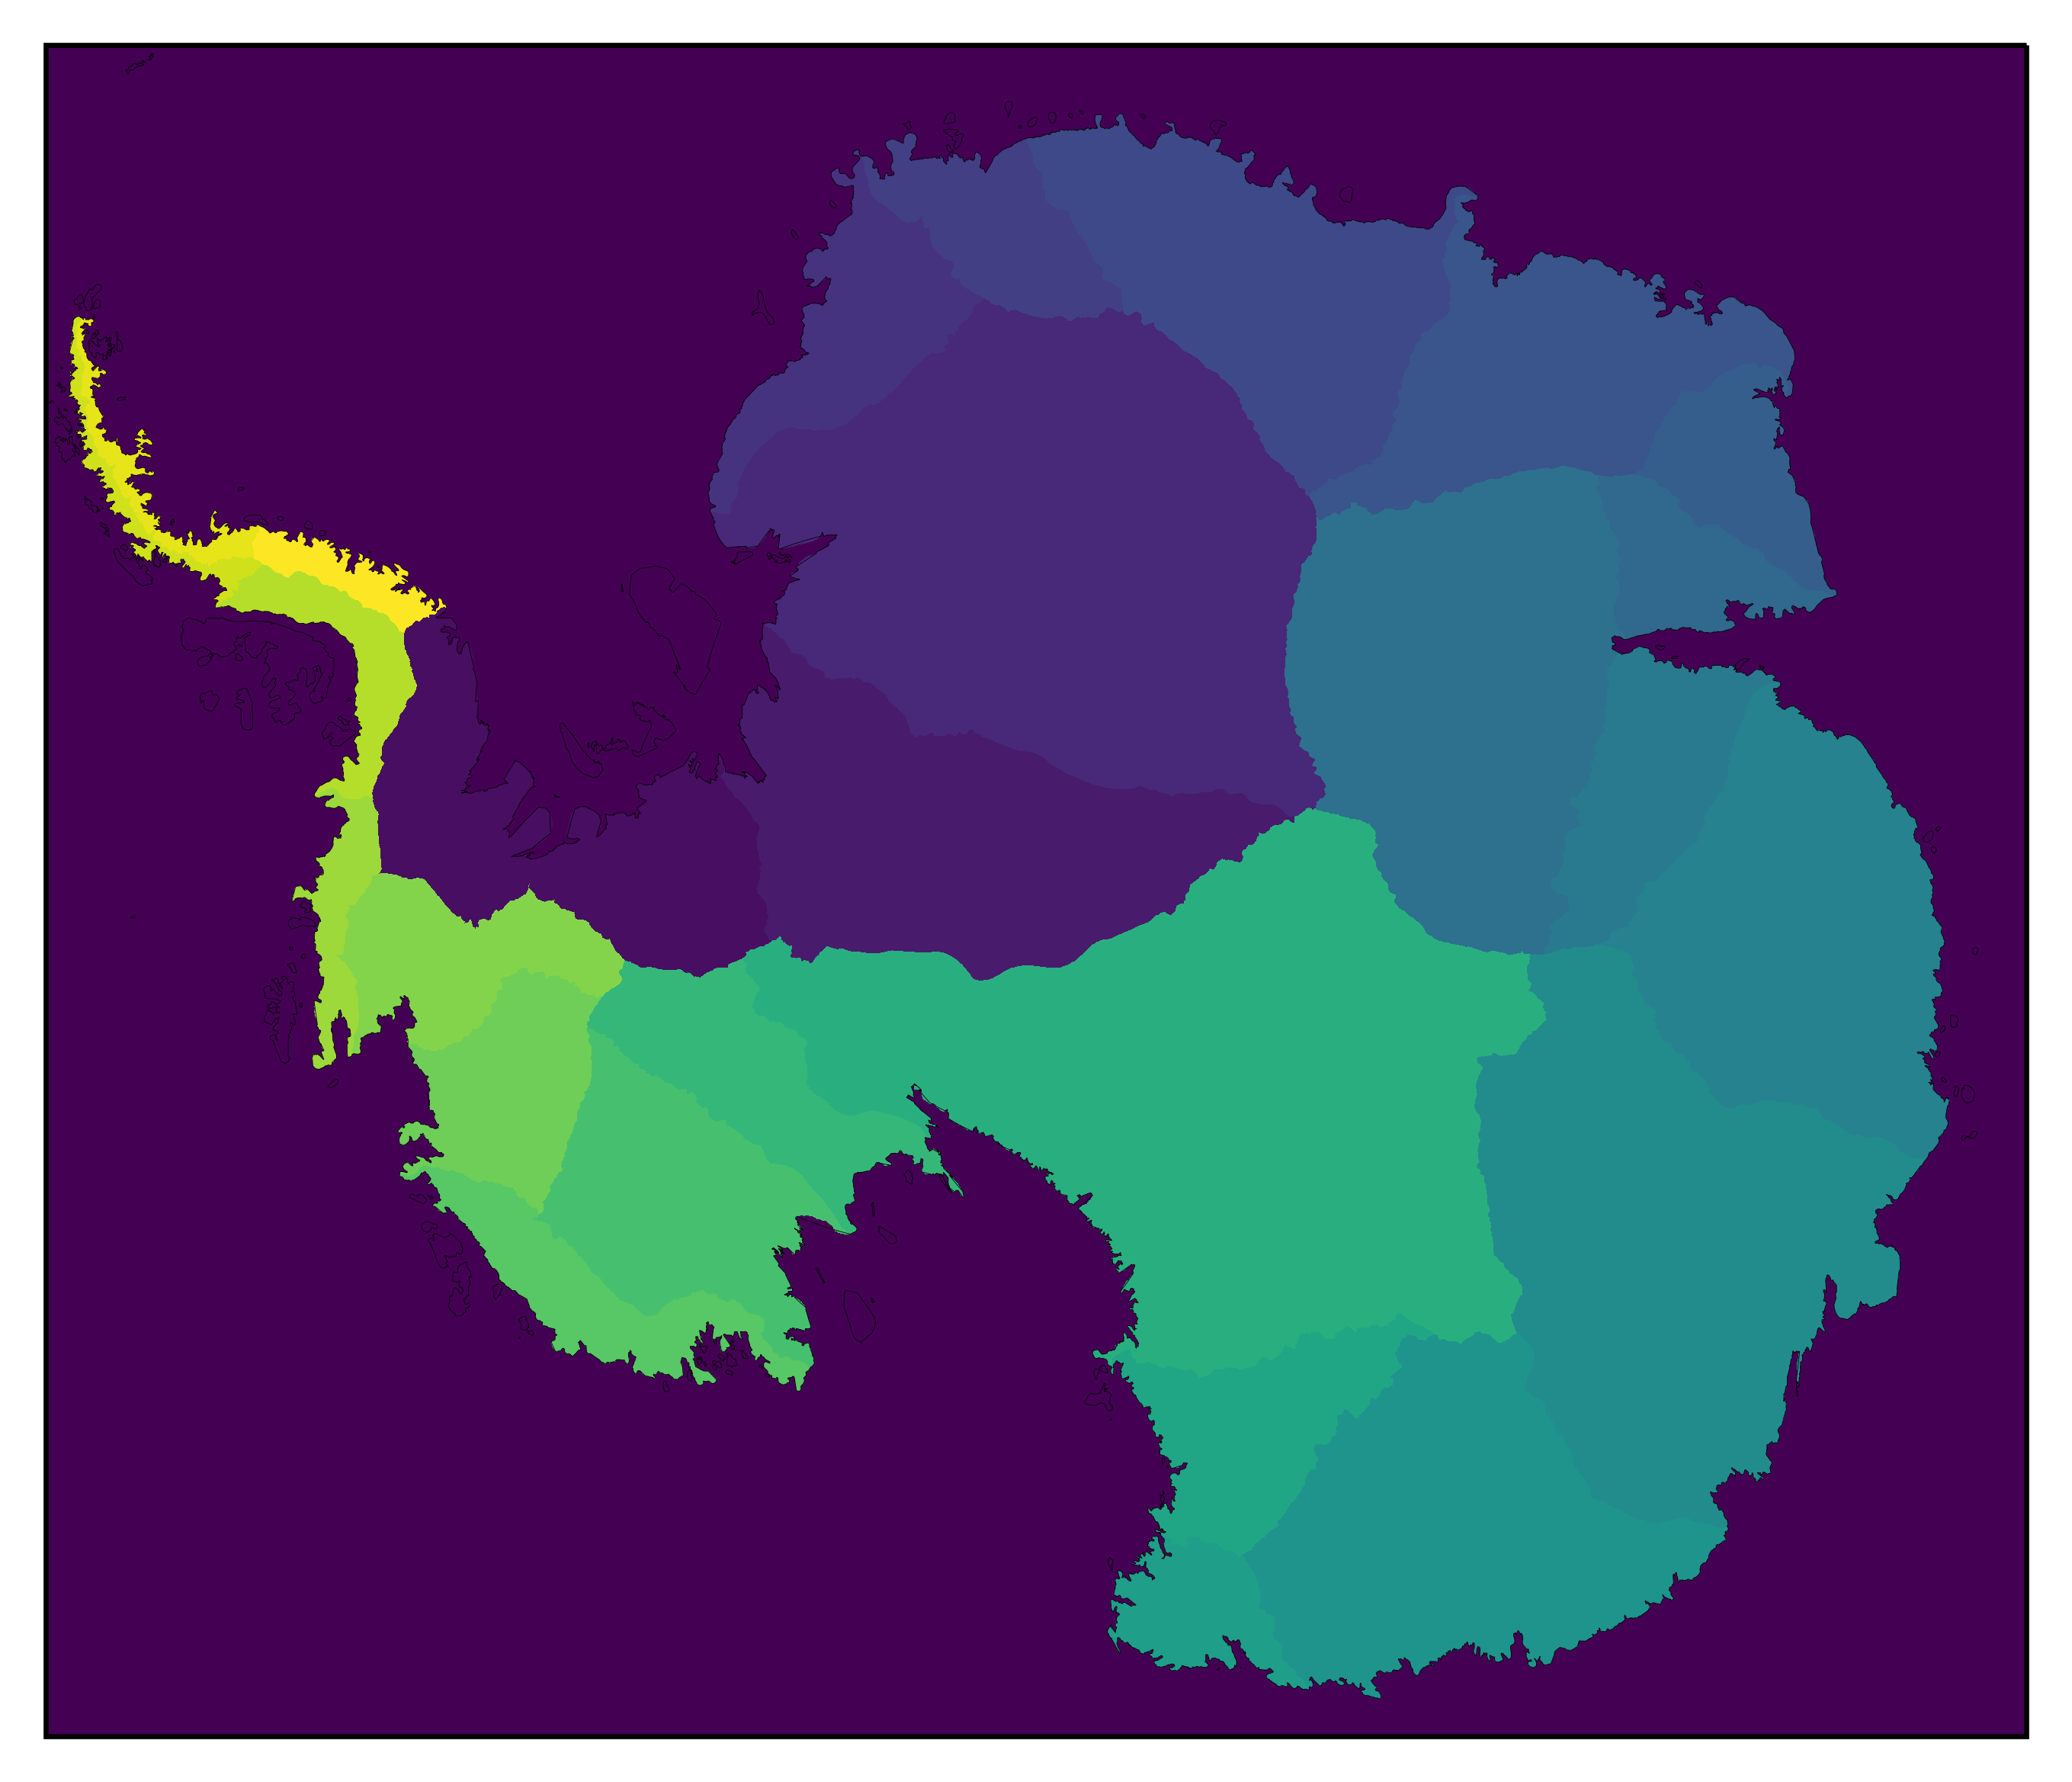

In [57]:
x_offset = 4_511_000
y_offset = 4_414_000

x = zwally.x
y = zwally.y

xs = x-x_offset
ys = y-y_offset

centered = zwally.assign_coords(x=xs, y=ys)

fig = plt.figure(dpi=600)
ax = plt.axes(projection=ccrs.SouthPolarStereo())

kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)
ax.pcolormesh(xs, ys, centered.basins, transform = ccrs.Stereographic(**kw))

ax.set_aspect('equal')

ax.coastlines(lw=0.1, resolution='10m')

In [65]:
# regrid to 16 km

path='/Users/jonniebarnsley/data/phd/Control/thickness/run001_control_thickness_0lev.nc'
bisicles = xr.open_dataset(path).mean(dim='t')
x = bisicles.x
y = bisicles.y
adjust = max(x)/2 + 4000 

x_centered = bisicles.x - adjust
y_centered = bisicles.y - adjust

centered_bisicles = bisicles.assign_coords(x=x_centered, y=y_centered)

interped = centered.interp(coords=centered_bisicles.coords, method='nearest')
mask_16km = interped.assign_coords(x=x, y=y).fillna(0)
mask_16km.to_netcdf('Users/jonniebarnsley/data/phd/masks/zwally_basins_16km.nc')

In [71]:
# regrid to 8 km

x_8km = np.arange(4000, 6_148_000, 8000)
adjust = max(x_8km)/2 + 2000 

x_centered = x_8km - adjust
y_centered = x_8km - adjust

interped = centered.interp(coords={'x':x_centered, 'y': y_centered}, method='nearest')
mask_8km = interped.assign_coords(x=x_8km, y=x_8km).fillna(0)
mask_8km.to_netcdf('Users/jonniebarnsley/data/phd/masks/zwally_basins_8km.nc')

### With ice shelves

In [21]:
res1km = xr.open_dataset('/Users/jonniebarnsley/data/phd/masks/zwally_basins_extended_1km.nc')
res1km

<xarray.Dataset>
Dimensions:  (x: 6144, y: 6144)
Coordinates:
  * x        (x) float64 500.0 1.5e+03 2.5e+03 ... 6.142e+06 6.142e+06 6.144e+06
  * y        (y) float64 500.0 1.5e+03 2.5e+03 ... 6.142e+06 6.142e+06 6.144e+06
Data variables:
    crs      int32 ...
    basin    (y, x) float64 ...
Attributes:
    Conventions:         CF-1.7
    component_0:         basin
    filetype:            VanillaAMRFileType
    crs_EPSG:            0
    num_components:      1
    num_levels:          1
    crs_origin_x:        0.0
    crs_origin_y:        0.0
    dx:                  1000.0
    Conversion_history:  Carried out by J R Barnsley on login2.arc3.leeds.ac....

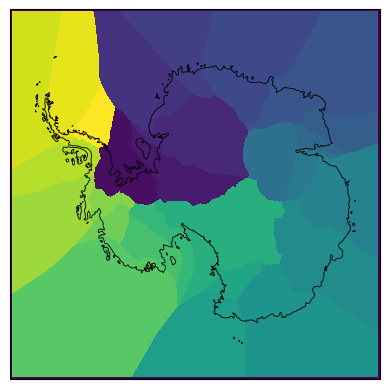

In [6]:
x = res1km.x
y = res1km.y

xs = x - x.mean()
ys = y - y.mean()

basin = res1km.basin

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.SouthPolarStereo()})
kw = dict(central_latitude=-90, central_longitude=0, true_scale_latitude=-70)
ax.pcolormesh(xs, ys, basin, transform=ccrs.Stereographic(**kw))
ax.set_aspect('equal')
ax.coastlines(lw=0.6)

In [26]:
res16km = res1km.coarsen(x=16, y=16).max()
res8km = res1km.coarsen(x=8, y=8).max()


In [29]:
res16km.to_netcdf('/Users/jonniebarnsley/data/phd/masks/zwally_basins_extended_16km.nc')
res8km.to_netcdf('/Users/jonniebarnsley/data/phd/masks/zwally_basins_extended_8km.nc')

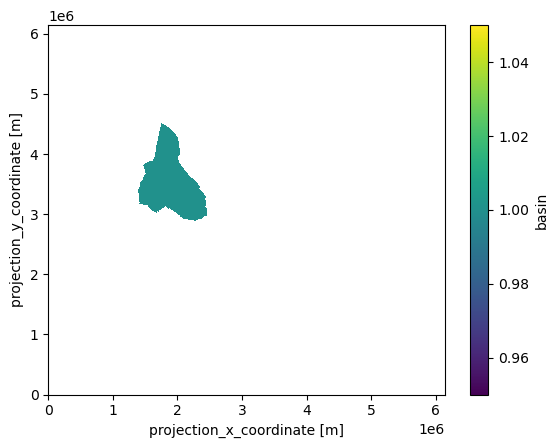

In [32]:
basin.where(basin == 1).plot()

In [13]:
import re
line = 'run001_control'

match = re.search(r'run(\d{3})', line)
match.group(0)

'run001'